In [1]:
from tifffile import imread
import os
from os.path import exists
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

## Parameters and path

In [22]:
um_per_pixel = 0.117
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig2_diffusion analysis/PAINT_like_local_domain"
os.chdir(folder_save)

fname = "20221031-FL_noTR_20ms_Replicate1_FOV-7-RNA-PAINT_spots_reformatted.csv"

plow = 5  # imshow intensity percentile
phigh = 95
line_color = "white"  # #00274C
scalebar_color = "white"

cmap_color_start = "black"
cmap_color_end = "#9a3324"
cmap_name = "dark2red"
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
    N=200,
)


scalebar_length_um = 5
scalebar_length_pxl = scalebar_length_um / um_per_pixel

## Construct PAINT image

In [ ]:
df = pd.read_csv(fname)

In [6]:
scaling_factor = 2
um_per_pixel_PAINT = um_per_pixel / scaling_factor
xedges = np.arange((418 + 1) * scaling_factor)
yedges = np.arange((674 + 1) * scaling_factor)
img_PAINT, _, _ = np.histogram2d(x=df["x"], y=df["y"], bins=(xedges, yedges))

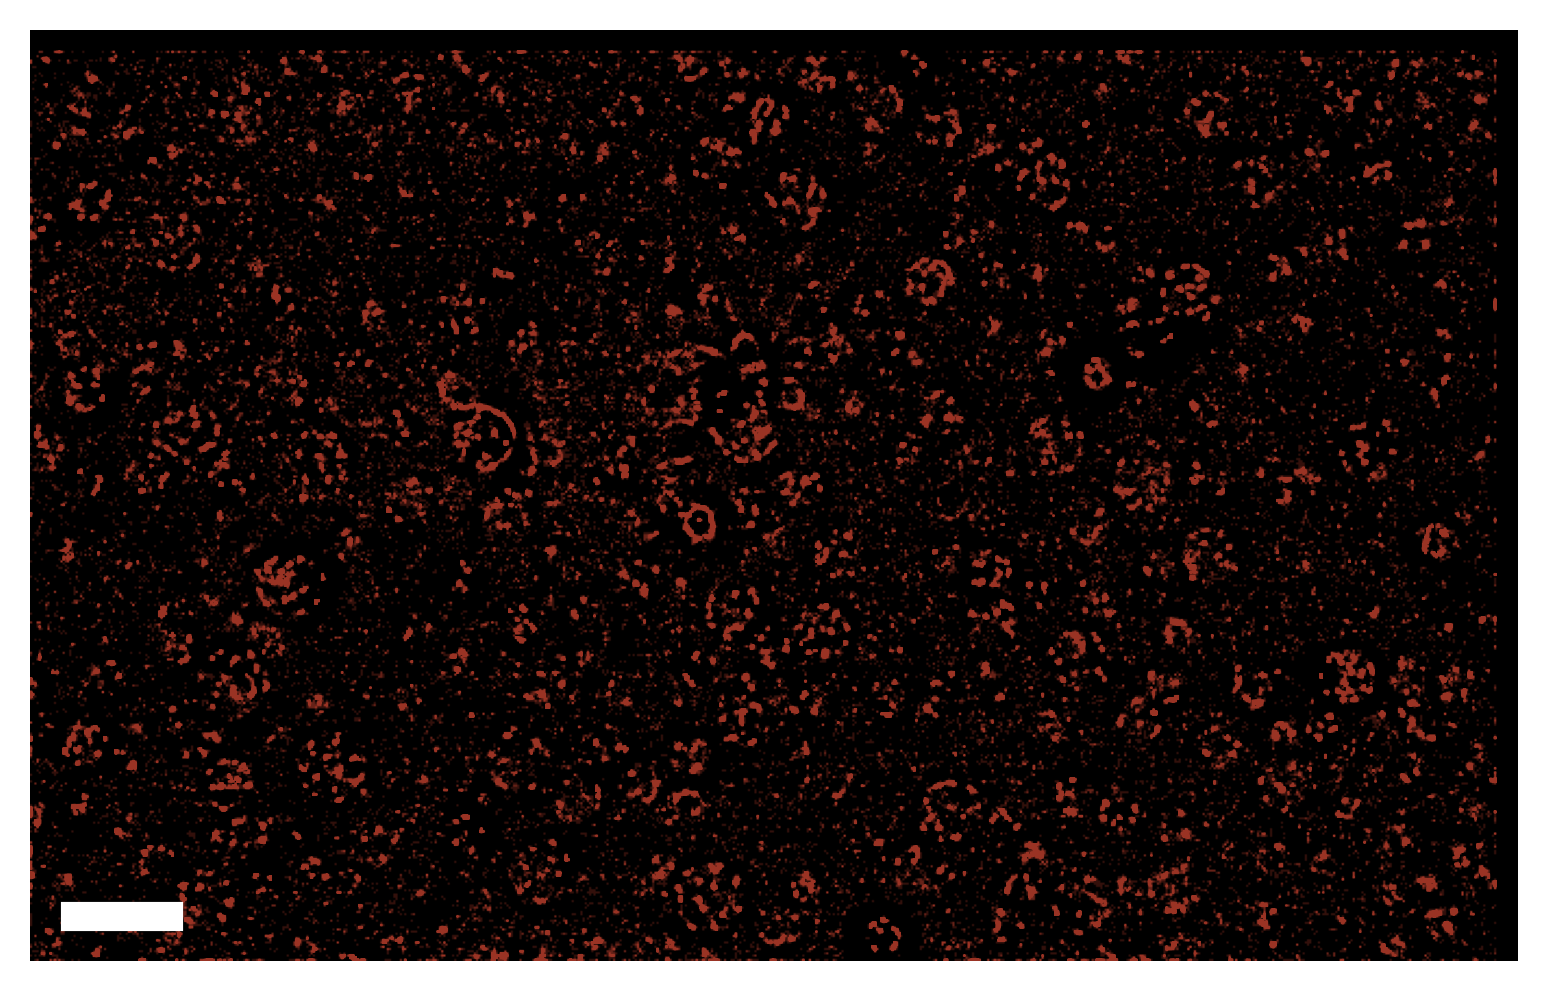

In [24]:
# full size: 418x674
zoom_in_x = (0, 418)
zoom_in_y = (0, 674)
scale_bar_offset = 20

plt.figure(dpi=300)
# Contrast stretching
vmin, vmax = np.percentile(img_PAINT, (plow, phigh))
plt.imshow(
    img_PAINT,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
)
plt.plot(
    [scale_bar_offset, scale_bar_offset + scalebar_length_pxl],
    [scale_bar_offset, scale_bar_offset],
    "-",
    color=scalebar_color,
    lw=7,
)
plt.gca().invert_yaxis()
plt.axis("scaled")
plt.axis("off")
fname_save = fname.split("RNA")[0] + "PAINT_overview.png"
plt.savefig(fname_save, bbox_inches="tight", format="png", dpi=1200)
plt.show()

# Zoom in

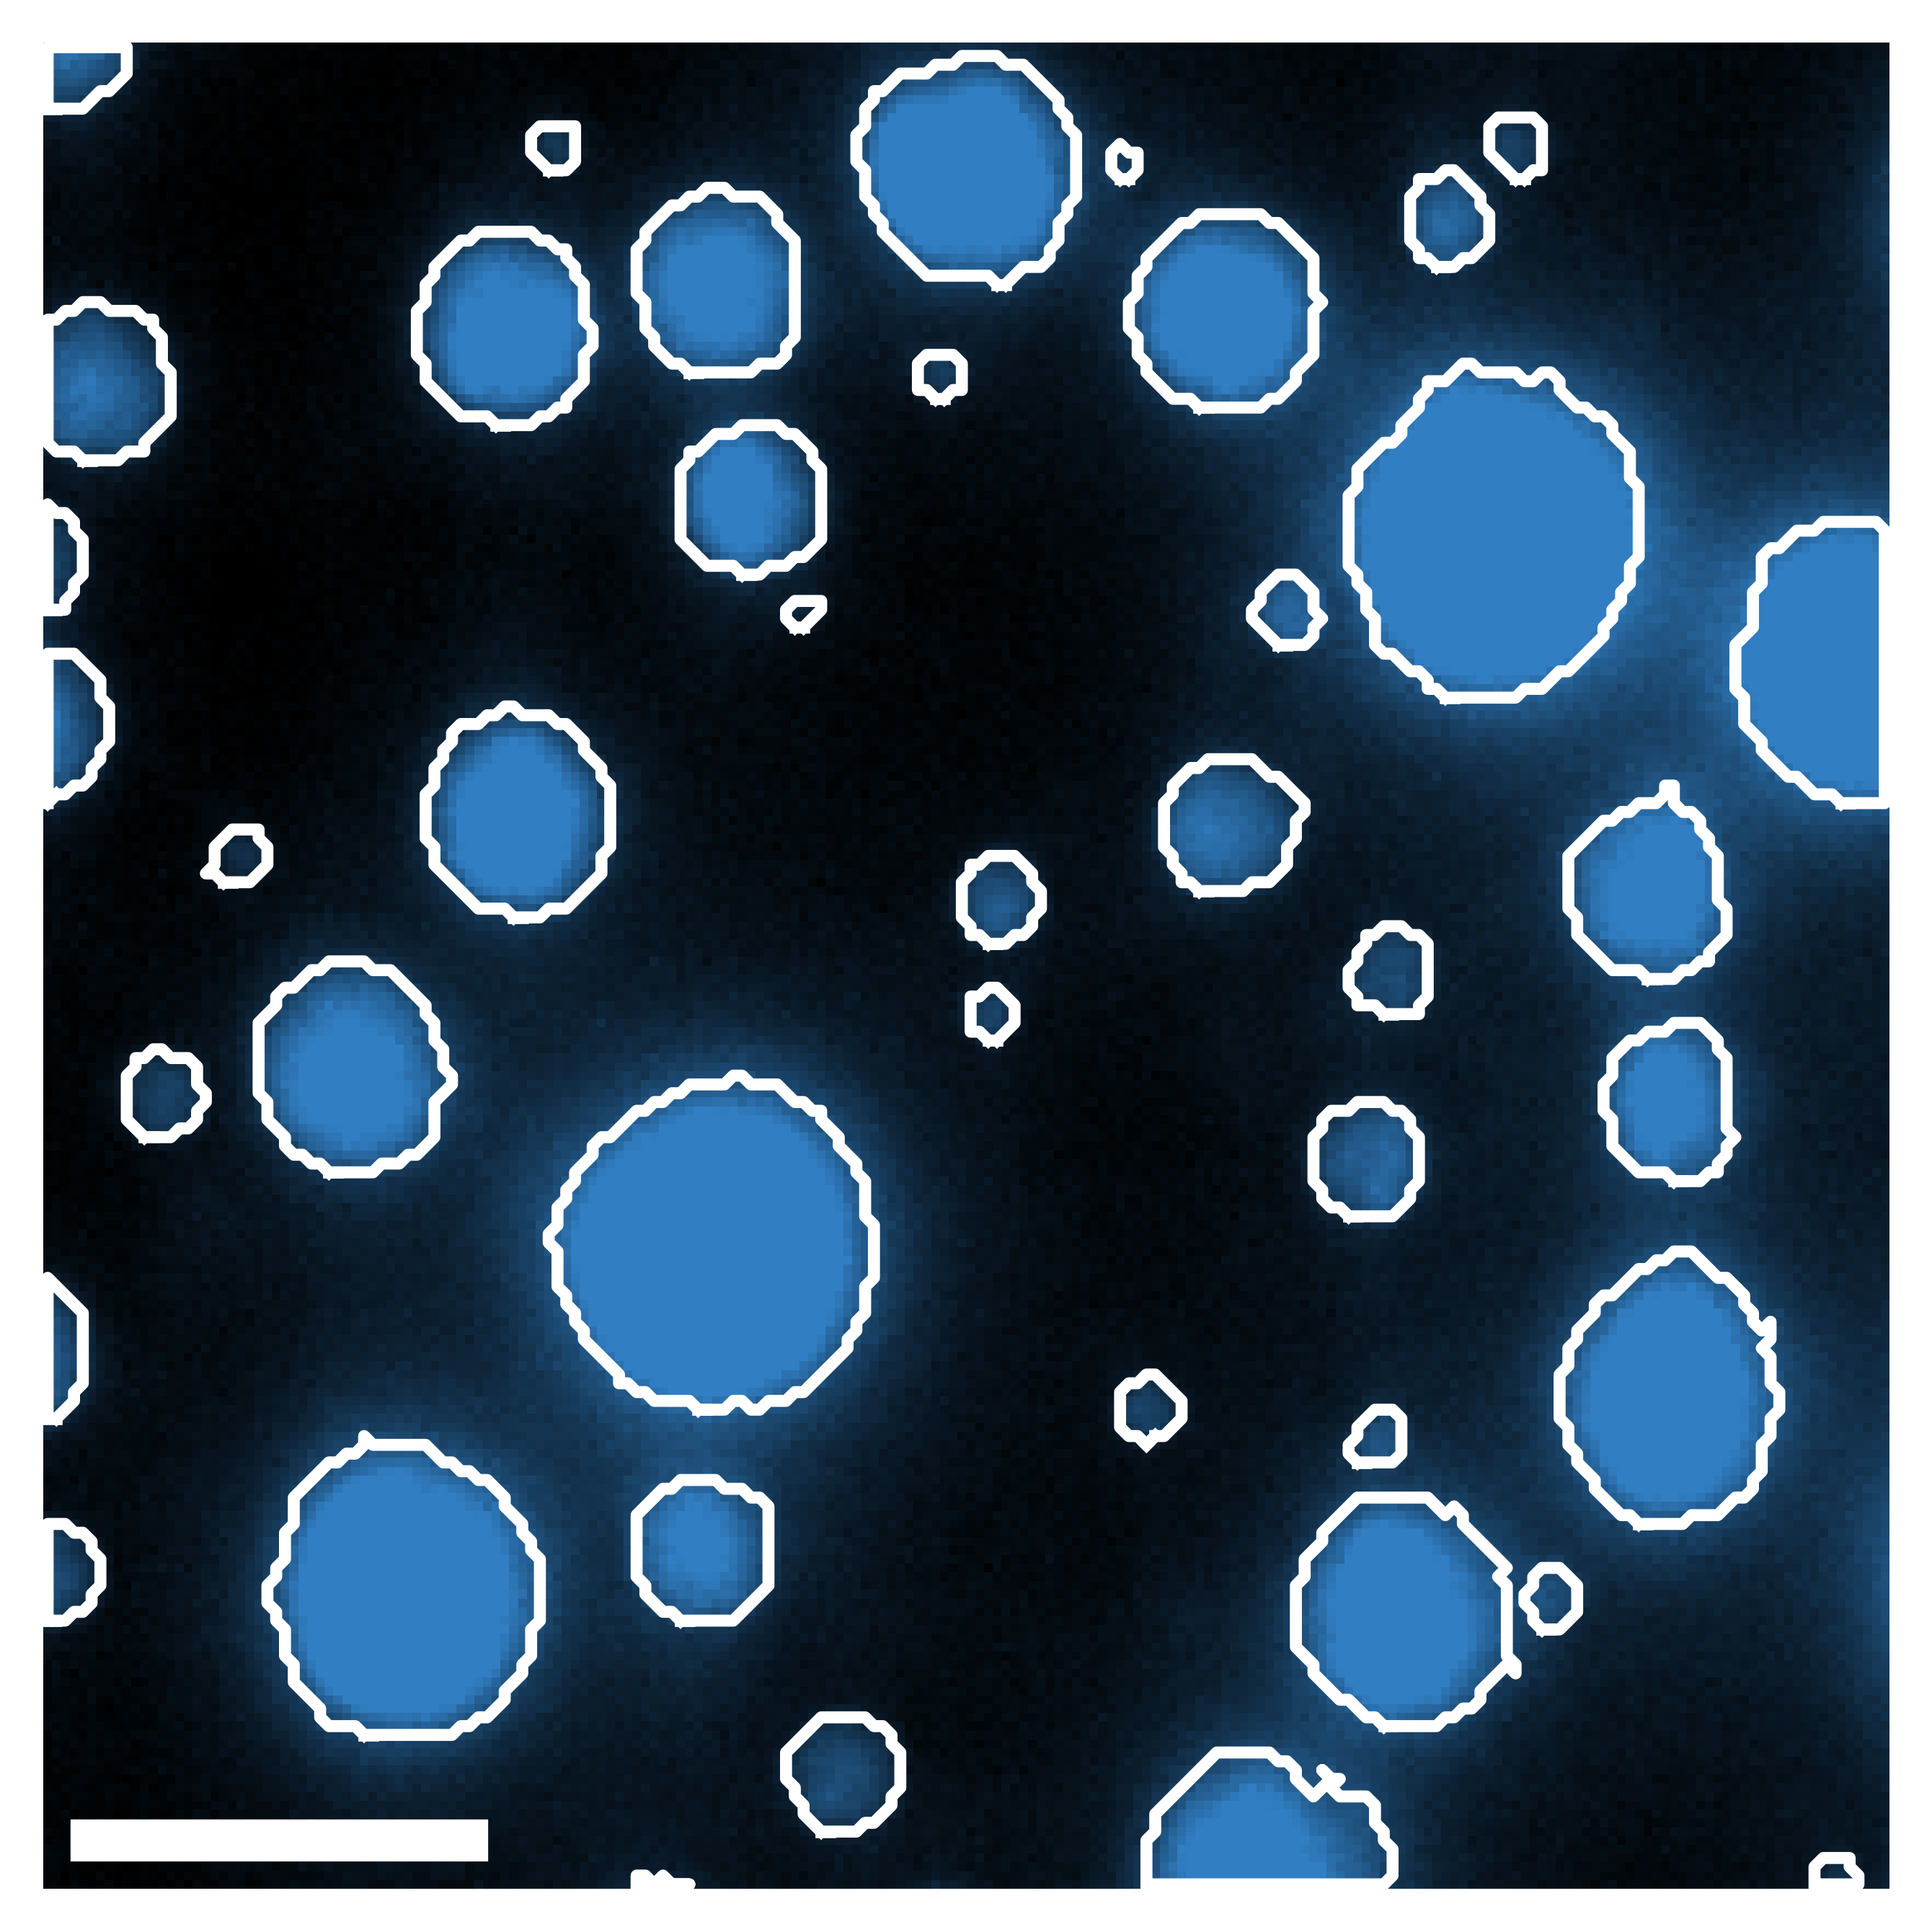

In [15]:
# full size: 418x674
zoom_in_x = (80, 290)
zoom_in_y = (100, 310)
saving_switch = True
plot_axis = False
scale_bar_offset = 5

# Cropping
ilastik_output_toplot = ilastik_output[
    zoom_in_y[0] : zoom_in_y[1], zoom_in_x[0] : zoom_in_x[1]
]
img_toplot = img[zoom_in_y[0] : zoom_in_y[1], zoom_in_x[0] : zoom_in_x[1]]

mask_all_condensates = (
    2 - ilastik_output_toplot
)  # background label=2, condensate label=1

# find contours coordinates in binary edge image. contours here is a list of np.arrays containing all coordinates of each individual edge/contour.
contours, _ = cv2.findContours(
    mask_all_condensates, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE
)

plt.figure(dpi=600)
# Contrast stretching
vmin, vmax = np.percentile(img_toplot, (plow, phigh))
plt.imshow(img_toplot, cmap=cmap, vmin=vmin, vmax=vmax)
for cnt in contours:
    x = cnt[:, 0][:, 0]
    y = cnt[:, 0][:, 1]
    plt.plot(x, y, "-", color=line_color, linewidth=2)
    # still the last closing line will be missing, get it below
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, "-", color=line_color, linewidth=2)

plt.xlim(0, img_toplot.shape[0])
plt.ylim(0, img_toplot.shape[1])
plt.tight_layout()
plt.axis("scaled")
if not plot_axis:
    plt.axis("off")


# plot scale bar
plt.plot(
    [scale_bar_offset, scale_bar_offset + scalebar_length_pxl],
    [scale_bar_offset, scale_bar_offset],
    "-",
    color=scalebar_color,
    lw=7,
)

if saving_switch:
    i = 0
    fname_save = (
        "Fig1_b_condensate_FOV-"
        + "x_"
        + str(zoom_in_x[0])
        + "_"
        + str(zoom_in_x[1])
        + "_y_"
        + str(zoom_in_y[0])
        + "_"
        + str(zoom_in_y[1])
        + ".png"
    )

    while exists(fname_save[:-4] + "-" + str(i) + ".png"):
        i += 1
    fname_save = fname_save[:-4] + "-" + str(i) + ".png"

    plt.savefig(fname_save, format="png", bbox_inches="tight")

plt.show()